## Generate an exact solution with a very fine grid and a very small time steps 

In [1]:
########### ERROR ANALYSIS ###########

import typing
from typing import Callable, Tuple, List, Union
from vedo.dolfin import plot, Latex, clear, histogram
from fenics import *
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
from solver_alix import solver, solver_ada,solver_para,solver_loop



embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink


### Choose a final time 

We do not want to loose too much time running the simulation too long after the temperature has plateau, therefore we plot the L2 norm at each time of the temperature. We decide that the temperature plateau at 2.5 seconds and therefore limits our analysis to that. 

Text(0.5, 1.0, '$\\|\\| u\\|\\|_2$')

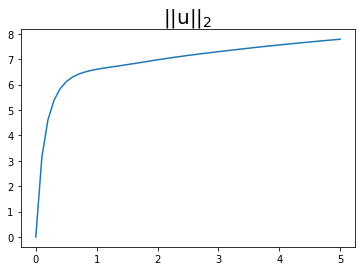

In [11]:

### Choose a final time 
"""
We do not want to loose too much time running the simulation too long after the temperature has plateau,
therefore we plot the L2 norm at each time of the temperature. We decide that the temperature plateau at 
2.5 seconds and therefore limits our analysis to that. 
"""

## Time 
## check whether solver does what we want : 
w = Expression(('2*x[1]*(1-x[0]*x[0])', '-2*x[0]*(1-x[1]*x[1])'), degree=3)
alpha0 = 1 # Initial value of alpha
tau =1/10 #Value of tau
epsilon = 1/20 #
dt = 1/10 #number of time steps taken
T =  5 #final time 
nx = 30 #size of the grid
ny = 30 #size of the grid
dt = 0.1

u_lists1, unorm_lists1, t_lists1 = solver(nx,ny,tau,alpha0, epsilon, dt, T,w)

plt.plot(np.linspace(0,T,len(unorm_lists1)),unorm_lists1)
plt.title("$\|\| u\|\|_2$", fontsize=20)



## Compute the error by looking at the difference at time T = 0.5, T = 1 and T = 2

We use the boundary condition to mimic the speed of the process and use a time steps that is adapted to the problem. Very small at the begining fast after. 

Adaptive
[0.001, 0.002, 0.0031, 0.0042, 0.0054, 0.0066, 0.0079, 0.0092, 0.0106, 0.012]
Comon times between fine and adaptive
[0.001  0.002  0.0031 0.0042 0.0054 0.0066 0.0079 0.0092 0.0106 0.012 ]
Adaptive
[0.002, 0.0042, 0.0065, 0.009, 0.0117, 0.0146, 0.0177, 0.021, 0.0245, 0.0282]
Comon times between fine and adaptive
[0.002  0.0042 0.0065 0.009  0.0117 0.0146 0.0177 0.021  0.0245 0.0282]
Adaptive
[0.005, 0.011, 0.0181, 0.0264, 0.036, 0.047, 0.0595, 0.0735, 0.0889, 0.1057]
Comon times between fine and adaptive
[0.005  0.011  0.0181 0.0264 0.036  0.047  0.0595 0.0735 0.0889 0.1057]
Adaptive
[0.01, 0.0238, 0.0423, 0.0661, 0.0954, 0.13, 0.1691, 0.2117, 0.2569, 0.3038]
Comon times between fine and adaptive
[0.01   0.0238 0.0423 0.0661 0.0954 0.13   0.1691 0.2117 0.2569 0.3038]
Adaptive
[0.02, 0.0545, 0.1081, 0.181, 0.2679, 0.3624, 0.4603, 0.5595, 0.6592, 0.7591]
Comon times between fine and adaptive
[0.02   0.0545 0.1081 0.181  0.2679 0.3624 0.4603 0.5595 0.6592 0.7591]
Adaptive
[0.05, 0

Text(0.5, 1.0, 'Adaptive time steps')

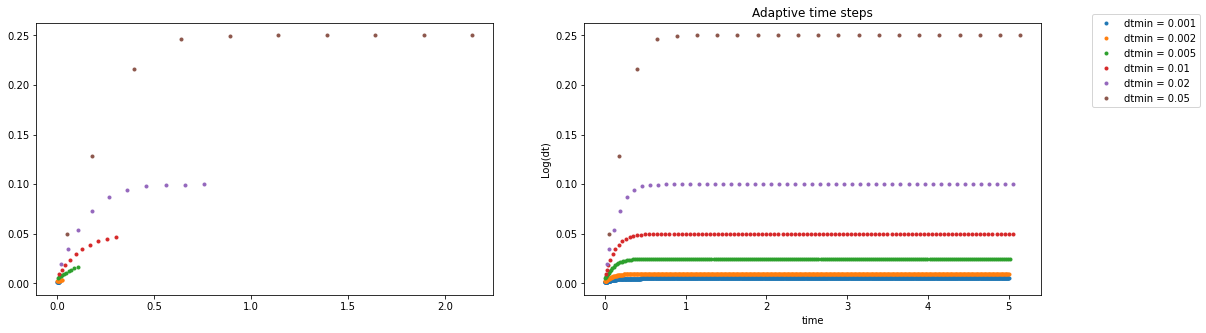

In [143]:
## Plots
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 5)) #create the figure 
nsee = 10 #parameter to see better whats going on on plots


## Parameters of the problems
tau = 1/10 
T=5

# code a function to compute the next step
def next_dt(dtmin,dtmax,prevt,tau):
    return (dtmax-dtmin)*(1-np.exp(-prevt/tau))+dtmin

# Code a function to yield a list of the time steps at each time
def gen_dtlist(dtmin,tau,T):
    dtmax = 5*dtmin #the max time steps is 10 times the smaller time steps 
    t=0 #time = 0 to start
    dt_list = [] #create an empty list to collect the values of the steps 
    t_list = [] #create an empty list to collect at which time we measure the time steps 
    while t<T: #loop until we arrive at time t
        dtnext = np.round(next_dt(dtmin,dtmax,t,tau),4) #compute the next dt
        dt_list.append(dtnext) #append it to the list of dt     
        t+=dtnext #compute the next time 
        t = round(t,10) #avoid numerical error coming from numerical scheme
        t_list.append(t) #append it to the list of dt 
    return(t_list,dt_list) #return the list of time and dt 

#Generate the ultra fine grid for sake of comparison 
t=0
dtfine = 0.0001
t_listfine = []
while t<T:
    t=t+dtfine
    t = round(t,10)
    t_listfine.append(t)


# Generate the time steps at different values of dt min for the sake of comparison 
dtfine = 1/10000 #select the finest grid. 
Nlist = np.array([10,20,50,100,200,500])
dtmin_list = Nlist*dtfine
for ni in Nlist:
    dtmin_i = ni*dtfine
    t_list, dt_list = gen_dtlist(dtmin_i,tau,T)
    ax1.plot(t_list[0:nsee],(dt_list[0:nsee]),".",label = "dtmin = "+str(dtmin_i))
    ax2.plot(t_list,dt_list,".",label = "dtmin = "+str(dtmin_i))
    print("Adaptive")
    print(t_list[0:nsee])
    print("Comon times between fine and adaptive")
    print(np.intersect1d(t_listfine,t_list)[0:nsee])

plt.plot()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("time")
plt.ylabel("Log(dt)")
plt.title("Adaptive time steps")



Now that we have generated our time steps, we want to try it out in the adaptive step size function and see against a coarse and fine grid. 

### Test the adaptive time steps 

Below we show that the adaptive time steps implementation returns the appropriate values of u and is stable . Firstly we compute an extremly precise solutions: 

In [144]:
## Set up parameter
w = Expression(('2*x[1]*(1-x[0]*x[0])', '-2*x[0]*(1-x[1]*x[1])'), degree=3)
alpha0 = 1 # Initial value of alpha
tau =1/10 #Value of tau
epsilon = 1/20 #
dt = 0.0001 #number of time steps taken
T =  5 #final time 
nx = 30 #size of the grid
ny = 30 #size of the grid
u_listsE, unorm_listsE, t_listsE = solver(nx,ny,tau,alpha0, epsilon, dt, T,w)


KeyboardInterrupt: 

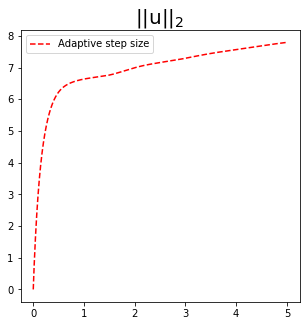

In [145]:
## Save the sol that took an hour to run 
# name_file = "Alixcode/err_analysis_unormE.csv"
# with open(name_file, 'wb') as f:
#     pickle.dump(unorm_listsE, f)
name_file = "Alixcode/err_analysis_unormE.csv"
with open(name_file, 'rb') as f:
    unorm_listsE = pickle.load(f)

# # name_file = "Alixcode/err_analysis_ulistE.csv"
# # with open(name_file, 'wb') as f:
# #     pickle.dump(u_listsE, f)
name_file = "Alixcode/err_analysis_ulistE.csv"
with open(name_file, 'rb') as f:
    u_listsE = pickle.load(f)

# # name_file = "Alixcode/err_analysis_tlistE.csv"
# # with open(name_file, 'wb') as f:
# #     pickle.dump(t_listsE, f)
name_file = "Alixcode/err_analysis_tlistE.csv"
with open(name_file, 'rb') as f:
    t_listsE = pickle.load(f)

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5)) #create the figure 
ax1.plot(t_listsE,unorm_listsE,"--",color="red",label = "Adaptive step size")
ax1.set_title("$\|\| u\|\|_2$", fontsize=20)
ax1.legend()

### Now we can compute the steps size with the different schemes and evaluate the errors


In [146]:
########### ERROR ANALYSIS ###########

import matplotlib.pyplot as plt
import typing
from typing import Callable, Tuple, List, Union
from vedo.dolfin import plot, Latex, clear, histogram
from fenics import *
import numpy as np
import pickle 
import time
from solver_alix import solver_ada ,solver, solver_para, solver_loop
######### ADATPIVE STEP SIZE #########
    
w = Expression(('2*x[1]*(1-x[0]*x[0])', '-2*x[0]*(1-x[1]*x[1])'), degree=3)
alpha0 = 1 # Initial value of alpha
tau =1/10 #Value of tau
epsilon = 1/20 #
T =  5 #final time 
nx = 30 #size of the grid
ny = 30 #size of the grid

## I - RESOLVE WITH EXACT SOLUTION LARGE GRID (COARSE)
dt = 0.05 # dt = 1/2
u_lists2, unorm_lists2, t_lists2 = solver(nx,ny,tau,alpha0, epsilon, dt, T,w)
 
## II - RESOLVE WITH EXACT SOLUTION FINE GRID 
dt = 0.01 # dt = 1/2
u_lists1, unorm_lists1, t_lists1 = solver(nx,ny,tau,alpha0, epsilon, dt, T,w)
 
## III - RESOLVE WITH ADAPTIVE STEPSIZE 
dtmin = 0.01 #number of time steps taken
t_list, dt_list = gen_dtlist(dtmin,tau,T)
u_listsa, unorm_listsa, t_listsa = solver_ada(nx,ny,tau,alpha0, epsilon, dt_list, T,w)



In [147]:
## compute the error : 
## I - Adaptive grid 
newt_listE = np.round(t_listsE,10)
time_matching = np.in1d(newt_listE,t_listsa)
error_adaptive = np.linalg.norm(unorm_listsa - unorm_listsE[time_matching])
print("Error in adaptive")
print(error_adaptive)

## II - Fine grid 
# time_matching = find_nearest_indexes(t_listsE,t_lists1)
# t_listsE[0::100] - t_lists1[0:-1]
error_finegrid = np.linalg.norm(unorm_lists1[0:-1] - unorm_listsE[0::100])
print("Error in fine")
print(error_finegrid)

## II - Coarse grid 
error_coarsegrid = np.linalg.norm(unorm_lists2[0:-1] - unorm_listsE[0::500])
print("Error in ,coarse")
print(error_coarsegrid)


Error in adaptive
0.20359742023611815
Error in fine
0.10207251454746598
Error in ,coarse
0.1927698700819153


Not sure it is necessary, here is a function to find the indexes of matching arrays 

In [126]:
def find_nearest_indexes(array1,array2,tol=10**(-10)):
    indexes_list = []
    n1 = len(array1)
    n2 = len(array2)
    k=0
    for i in range(n1):
        print(i)
        elem1 = array1[i]
        for j in range(k,n2):
            elem2 = array2[j]
            if np.abs(elem2-elem1)<tol:
                indexes_list.append(i)
                k=j
    return indexes_list

Number of steps for the adaptive step size
105
Number of steps for the fine step size
501
Number of steps for the coarse step size
101


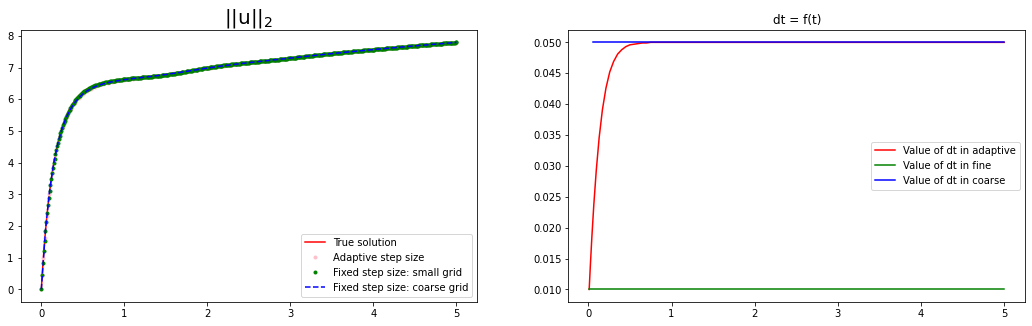

In [148]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 5)) #create the figure 

ax1.plot(t_listsE,unorm_listsE,color="red",label = "True solution")
ax1.plot(t_listsa,unorm_listsa,".",color="pink",label = "Adaptive step size")
ax1.plot(t_lists1,unorm_lists1,".",color="green",label = "Fixed step size: small grid")
ax1.plot(t_lists2,unorm_lists2,"--",color="blue",label = "Fixed step size: coarse grid")
ax1.set_title("$\|\| u\|\|_2$", fontsize=20)
ax1.legend()

dt_lista = t_listsa[1::]-t_listsa[0:len(t_listsa)-1]
dt_list1 = t_lists1[1::]-t_lists1[0:len(t_lists1)-1]
dt_list2 = t_lists2[1::]-t_lists2[0:len(t_lists2)-1]
ax2.plot(t_listsa[1::],dt_lista,color = "red",label = "Value of dt in adaptive")
ax2.plot(t_lists1[1::],dt_list1,color = "green",label = "Value of dt in fine")
ax2.plot(t_lists2[1::],dt_list2,color = "blue", label = "Value of dt in coarse")
ax2.set_title("dt = f(t)")
ax2.legend()

print("Number of steps for the adaptive step size")
print(len(t_listsa))
print("Number of steps for the fine step size")
print(len(t_lists1))
print("Number of steps for the coarse step size")
print(len(t_lists2))



### Show that implementing the adaptive time steps was worth the effort 
To show this, we will compute an exact solution with a very fine time steps, as dt = 0.0001. Then we use the adaptive time steps and the non adaptive time steps with the same number of loop ran (adjusting dt of the adaptive time steps consequently) and see whether we gain some accuracy. 

#### An exact solution that is very expensive to compute (1 hour)

In [128]:
name_file = "Alixcode/err_analysis_unormE.csv"
with open(name_file, 'rb') as f:
    unorm_listsE = pickle.load(f)

name_file = "Alixcode/err_analysis_ulistE.csv"
with open(name_file, 'rb') as f:
    u_listsE = pickle.load(f)

name_file = "Alixcode/err_analysis_tlistE.csv"
with open(name_file, 'rb') as f:
    t_listsE = pickle.load(f)

### Now compute for the adaptive step size solutions at coarser grid than the exact solution and compare adaptive step size to constant step size

In [206]:
## Compute the error between two 
def error_true_ada(time_array_true, time_array_ada, unorm_listsE, unorm_ada):
    newt_listE = np.round(time_array_true,10)
    time_matching = np.in1d(newt_listE,time_array_ada)
    error_adaptive = np.linalg.norm(unorm_ada - unorm_listsE[time_matching])
    return(error_adaptive)

def error_true_fixed(N, unorm_listsE, unorm_cst):
    len_cst = len(unorm_cst)
    len_norm = len(unorm_listsE[0::N])
    if len_cst == len_norm: 
        error_finegrid = np.linalg.norm(unorm_cst-unorm_listsE[0::N])
    elif len_cst > len_norm:
        error_finegrid = np.linalg.norm(unorm_cst[0:-1]-unorm_listsE[0::N])
    return(error_finegrid)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


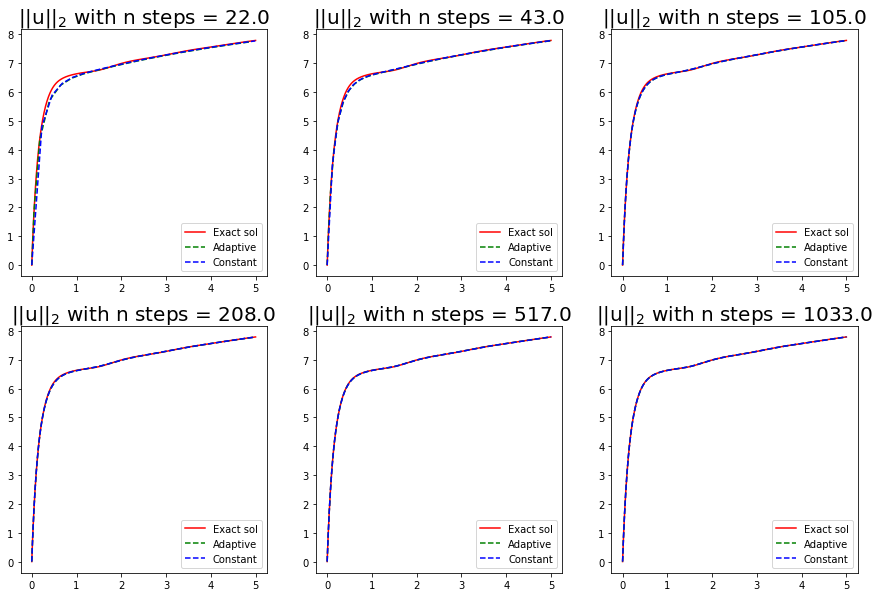

In [217]:
fig, (ax) = plt.subplots(2, 3, figsize=(15, 10)) #create the figure 
dtfine = 0.0001
Nlist = np.array([[500,250,100],[50,20,10]])
error_adaptive = []
num_steps_list = []

## Set up the parameters
error_adaptive = []
error_cst = []
num_steps_cst = []
num_steps_ada = []

for i in range(2):
    for j in range(3):

        ## 0 - Value of dtmin in adaptive time steps
        ni = Nlist[i,j]
        dtmin = ni*dtfine

        ## I - Adaptive time step
        t_list, dt_list = gen_dtlist(dtmin,tau,T)        
        u_listsa, unorm_listsa, t_listsa = solver_ada(nx,ny,tau,alpha0, epsilon, dt_list, T,w)
        ## compute the error on the adaptive time steps
        error_adaptive.append(error_true_ada(t_listsE, t_listsa, unorm_listsE, unorm_listsa)) 

        ## II- Constant step size
        ## Evaluate the number of steps taken in the constant time steps- round to the nearest 10th for comparison
        num_steps = (len(t_listsa)/5) # number of steps to take in 1 sec
        num_steps_ada.append(num_steps)
        dt_cst = round(1/num_steps,3) # get a dt that is comparable to dtfine (by rounding to the nearest 3 decimals)
        new_num_steps = 1/dt_cst # get a new number of time steps, hopefully comparable
        num_steps_cst.append(new_num_steps) #save the value of the new n
        Ni = int(dt_cst/dtfine) #now we need to know how to compute the error and need to know what is the Ni, so I can take every N steps to compare the error
        # Now we can compute the scheme with our new constant step size
        u_list, unorm_cst, t_list = solver(nx,ny,tau,alpha0, epsilon, dt_cst, T,w)
        ## compute the error on the cst step size 
        error_cst.append(error_true_fixed(Ni, unorm_listsE, unorm_cst))

        ax[i,j].plot(t_listsE,unorm_listsE,color="red",label = "Exact sol")
        #ax[i,j].plot(t_listsa,unorm_listsa,"x",color="green")
        ax[i,j].plot(t_listsa,unorm_listsa,"--",color="green",label = "Adaptive")
        #ax[i,j].plot(t_list,unorm_cst,"x",color="blue")
        ax[i,j].plot(t_list,unorm_cst,"--",color="blue",label = "Constant")
        ax[i,j].legend()
        ax[i,j].set_title("$\|\| u\|\|_2$ with n steps = "+str(num_steps*T), fontsize=20)
        ax[i,j].legend()

# plt.plot(error_adaptive)


Text(0.5, 1.0, 'Error plot on the norm of U with different computational cost')

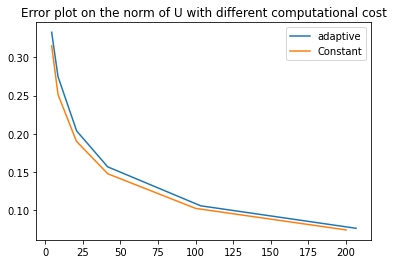

In [219]:
plt.plot(num_steps_ada,error_adaptive,label= "adaptive")
plt.plot(num_steps_cst,error_cst,label = "Constant")
plt.legend()
plt.title("Error plot on the norm of U with different computational cost")

### Now compare the error compare to the exact solution by comparing the values at the right times

In [89]:
## Create a function to compare the error between the very fine grid and the adptive step size 
dtmin = 0.01
t_listA, dt_listA = gen_dtlist(dtmin,tau,T)
u_listsa, unorm_listsa, t_listsa = solver_ada(nx,ny,tau,alpha0, epsilon, dt_listA, T,w)
num_steps = len(t_listsa)/5
u_list, unorm_list, t_list = solver(nx,ny,tau,alpha0, epsilon, 1/num_steps, T,w)

## compute the error at the right time 

u_listsE, unorm_listsE, t_listsE
np.intersect1d(t_listsE,t_listA)

array([], dtype=float64)

NameError: name 't_listsE' is not defined

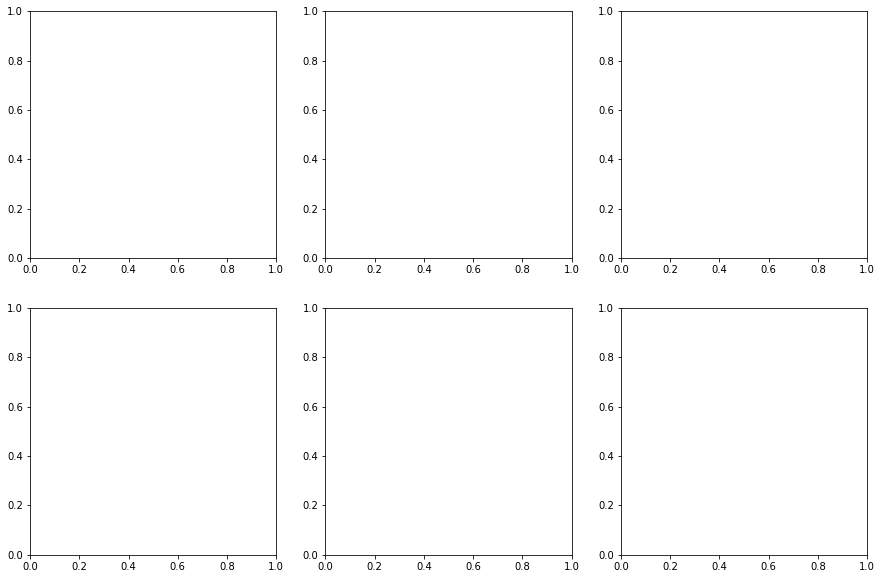

In [30]:
fig, (ax) = plt.subplots(2, 3, figsize=(15, 10)) #create the figure 
npower = [[1,2,3],[4,5,6]]
dt_list = np.power(1/2,npower)
error_adaptive = []
num_steps_list = []

## Set up the parameters
#mesh, V, u, v, f = solver_para(nx,ny)
for i in range(2):
    for j in range(3):
        dti = dt_list[i,j]
        u_listsa, unorm_listsa, t_listsa = solver_ada(nx,ny,tau,alpha0, epsilon, dti, T,w)
        num_steps = len(t_listsa)/5
        u_list, unorm_list, t_list = solver(nx,ny,tau,alpha0, epsilon, dt, T,w)
        ax[i,j].plot(t_listsE,unorm_listsE,color="red",label = "Exact sol")
        ax[i,j].plot(t_listsa,unorm_listsa,"x",color="green",label = "Adaptive")
        ax[i,j].plot(t_listsa,unorm_listsa,"--",color="green",label = "Adaptive")
        ax[i,j].plot(t_list,unorm_list,"x",color="blue",label = "Constant")
        ax[i,j].plot(t_list,unorm_list,"--",color="blue",label = "Constant")
        ax[i,j].legend()
        ax[i,j].set_title("$\|\| u\|\|_2$ with n steps = "+str(num_steps*T), fontsize=20)
        ax[i,j].legend()

# plt.plot(error_adaptive)


#### Find values of T at which we can compare the steps size with the exact solution. Assuming a very fine time grid for observation, we have: 
To do so, we will take the larger grid, find the value the closest to T = Tfixed (an arbitrary value of T at which we look the error) and then look in the very fine grid the corresponding closest value. 

In [31]:
## Write a function to find the index of nearest element
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

# Power of 
npower = np.array([[1,2,3,4],[5,6,7,8]])
dt_list = np.power(1/2,npower)

# Fixed time at which we evaluate the error
error_adaptiveL = []
error_constantL = []

# Find value of unorm in exact sol the closet to T of interest 
Ti = 5
idx = find_nearest(t_listsE,Ti) #find the index of the closest result of u to T=2
norm_listsETi = unorm_listsE[::idx] #find the value of unorm at T = Ti 
int_normE = np.trapz(norm_listsETi) #find the integral until T = 5 

# run through the different values of time steps 
for i in range(2):
    for j in range(3):
        # get the time steps
        dti = dt_list[i,j]
        print(dti)
        ## compute adaptive step size
        u_listsa, unorm_listsa, t_listsa = solver_ada(nx,ny,tau,alpha0, epsilon, dti, T,w) #run solver
        idx = find_nearest(t_listsa,2) #find the index of the closest result of u to T=2
        int_normsa =np.trapz(unorm_listsa[::idx])
        error_adapt = np.abs(int_normsa -int_normE) # find the error between the value of u with very fine grid and approximate u at this time
        error_adaptiveL.append(error_adapt)

        ## compute time steps 
        num_steps = len(t_listsa)/5 #number of steps
        u_list, unorm_list, t_list = solver(nx,ny,tau,alpha0, epsilon, 1/num_steps, T,w)
        idx = find_nearest(t_list,2) #find the index of the closest result of u to T=2
        int_norm = np.trapz(unorm_list[::idx])
        error_constant = np.abs(int_norm -int_normE) # find the error between the value of u with very fine grid and approximate u at this time
        error_constantL.append(error_constant)


0.5
0.25
0.125
0.03125
0.015625
0.0078125
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [1]:
plt.plot(error_adaptiveL,label = "adaptive")
# plt.plot(error_constantL,label = "constant")
plt.legend()
plt.title("Trapeozidale integrals of U norm")

NameError: name 'plt' is not defined

## Adaptive step size 
Clearly the adaptive step size is performing better on simulating the solution. 
Now the question is that if we can't compare exactly the time at which we compare our solutions, how are we supposed to compute a likelihood. One way would be to compare the observed data with noise 


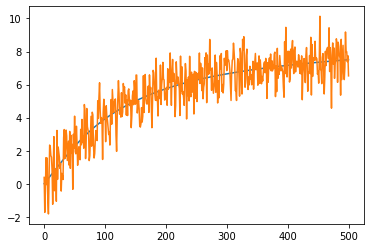

In [35]:
alpha0 = 1 # Initial value of alpha - start at something else
iterations = 100  # Lenght of the MCMC chain
tau =1 #Value of tau
epsilon = 1/20 #
num_steps = 100 #number of time steps taken
T = 5.0 #final time 
nx = 30 #size of the grid
ny = 30 #size of the grid
sigma_q = 0.5 #variance of the guess proposal
sigma_p = 1 #variance of the prior
mu_p = 0 #mean of the proposal 
sigma_l = 0.2 #variance of the likelihood
w = Expression(('2*x[1]*(1-x[0]*x[0])', '-2*x[0]*(1-x[1]*x[1])'), degree=3) # wind expression

## Generate the observed data
noise_star = 1 # noise added to the data
alpha_star = 0
nx_star=30
ny_star=30 

mesh, V, u, v, f = solver_para(nx_star,ny_star)
u_list, unorm_list, t_list=solver_loop(alpha0,mesh,V,u,v,f,tau, epsilon, num_steps, T,w)
ynorm_star = unorm_list + np.random.normal(np.zeros(np.shape(unorm_list)), noise_star)

# Compute the integral of y over 1:T 

plt.plot(unorm_list)
plt.plot(ynorm_star)
plt.show()

#### Check that the adaptive scheme methods yields the same results when splitting the code than when you don't split the code. 



In [2]:
####### ADATPIVE STEP SIZE #########

w = Expression(('2*x[1]*(1-x[0]*x[0])', '-2*x[0]*(1-x[1]*x[1])'), degree=3)
alpha0 = 1 # Initial value of alpha
iterations = 100 # Lenght of the MCMC chain
tau =1/20 #Value of tau
epsilon = 1/200 #
T =  5 #final time 
nx = 30 #size of the grid
ny = 30 #size of the grid
dt = 0.1 #number of time steps taken

## Split adaptive method : 
mesh, V, u, v, f = solver_para(nx,ny)
u_list, unorm_list, t_list = solver_loop_ada(alpha0,mesh,V,u,v,f,tau, epsilon, dt, T,w)

## Non split method 
# u_listsa, unorm_listsa, t_listsa = solver_ada(nx,ny,tau,alpha0, epsilon, dt, T,w)

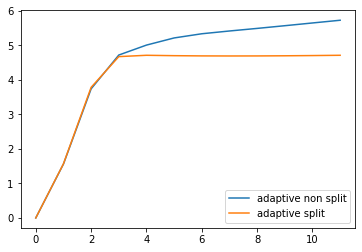

In [10]:
plt.plot(unorm_listsa, label = "adaptive non split")
plt.plot(unorm_list,label = "adaptive split")
plt.legend()

### Floor function 


[0.08 0.12 0.12 0.12 0.12 0.16 0.16 0.16 0.16 0.16 0.2  0.2  0.2  0.2
 0.2  0.24 0.24 0.24 0.24 0.24 0.28 0.28 0.28 0.28 0.28 0.28 0.32 0.32
 0.32 0.32 0.32 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.4  0.4  0.4  0.4
 0.4  0.4  0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.48 0.48 0.48 0.48 0.48
 0.48 0.48 0.48 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.52 0.56 0.56 0.56
 0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.6  0.6  0.6  0.6  0.6  0.6  0.6
 0.6  0.6  0.6  0.64 0.64 0.64 0.64 0.64 0.64 0.64 0.64 0.64 0.64 0.64
 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.72 0.72
 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.72 0.76 0.76
 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76
 0.76 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8
 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.84 0.84 0.84 0.84 0.84 0.84 0.84
 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84
 0.84 0.84 0.84 0.84 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88
 0.88 0.88

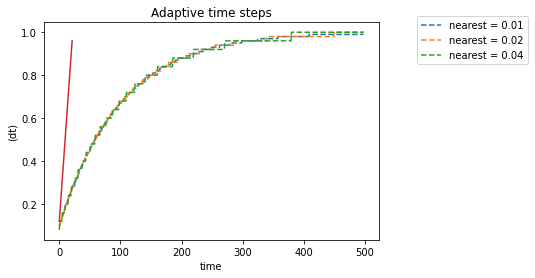

In [74]:
## getting an adaptive time steps
tau = 1/10 
dt = 0.1
t = np.linspace(0,0.5,int(T*100))
x = 1 
npower = np.array(range(1,5))
dt_list = 1/2**(npower)

nsee = -1
dt_max = 1
t_list = ((1-np.exp(-t/tau)) *0.9+0.1)*dt_max
time_der1 = np.round(t_list/0.01)*0.01
plt.plot(time_der1[0:nsee],"--",label = "nearest = "+str(0.01))
time_der2 = np.round(t_list/0.02)*0.02
plt.plot(time_der2[0:nsee],"--",label = "nearest = "+str(0.02))
time_der3 = np.round(t_list/0.04)*0.04
plt.plot(time_der3[0:nsee],"--",label = "nearest = "+str(0.04))

intersect = np.intersect1d(np.intersect1d(time_der2,time_der3), time_der1)
plt.plot(intersect)
plt.plot()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("time")
plt.ylabel("(dt)")
plt.title("Adaptive time steps")
print(time_der3)

In [73]:
print(np.intersect1d(time_der3, time_der2))

print(np.intersect1d(time_der1, time_der2))
intersect = np.intersect1d(np.intersect1d(time_der2,time_der3), time_der1)

[0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52 0.56 0.6  0.64
 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.  ]
[0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28 0.3  0.32 0.34 0.36
 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64
 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92
 0.94 0.96 0.98]
[0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52 0.56 0.6  0.64
 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96]


In [18]:
npower = np.array(range(1,5))
dt_list = 1/2**(npower)
dt_list

array([0.5   , 0.25  , 0.125 , 0.0625])